In [1]:
#from cresset import flare

In [2]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole
from rdkit.Chem.rdDepictor import Compute2DCoords
from IPython.display import SVG

`draw_mols` is a simple helper function to draw molecules in a grid using the new C++ code to benefit from atom/bond highlighting when an MCS is supplied as an optional parameter.

In [3]:
def draw_mols(mols, grid=(600, 150, 150, 150), padding=0.15, mcs_res=None):
    d = rdMolDraw2D.MolDraw2DSVG(*grid)
    d.drawOptions().padding = padding
    pmols = [rdMolDraw2D.PrepareMolForDrawing(m) for m in mols]
    [Compute2DCoords(pm) for pm in pmols]
    highlight_atoms = None
    highlight_bonds = None
    if (mcs_res is not None):
        if isinstance(mcs_res, rdFMCS.MCSResult):
            smarts_string = mcs_res.smartsString
        elif isinstance(mcs_res, MCS.MCSResult):
            smarts_string = mcs_res.smarts
        else:
            raise TypeError("mcs_res should be an instance of either "
                            "rdFMCS.MCSResult or MCS.MCSResult")
        mcs_mol = Chem.MolFromSmarts(smarts_string)
        mcs_bonds = [(b.GetBeginAtomIdx(), b.GetEndAtomIdx())
                     for b in mcs_mol.GetBonds()]
        highlight_atoms = []
        highlight_bonds = []
        for m in mols:
            match = m.GetSubstructMatch(mcs_mol)
            highlight_atoms.append(match)
            highlight_bonds.append([m.GetBondBetweenAtoms(
                match[i], match[j]).GetIdx() for i, j in mcs_bonds])
    d.DrawMolecules(pmols, highlightAtoms=highlight_atoms,
                   highlightBonds=highlight_bonds)
    d.FinishDrawing()
    svg = d.GetDrawingText()
    return SVG(svg)

Here I will run again all examples of the Jupyter notebook that I am running using RDKit release `2019_04_3` on a patched version of the RDKit which implement the behavior that I consider more chemically intuitive and useful. First let's check that the patch has not broken the MCS between &alpha;-methylnaphthalene and &beta;-aminonaphthalene:

In [4]:
a_methyl_naphthalene = Chem.MolFromSmiles("Cc1cccc2ccccc12")

In [5]:
b_amino_naphthalene = Chem.MolFromSmiles("Nc1ccc2ccccc2c1")

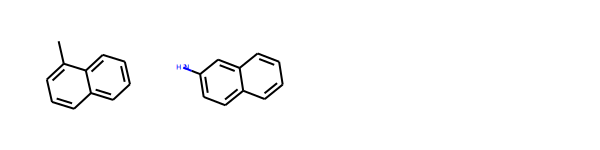

In [6]:
draw_mols((a_methyl_naphthalene, b_amino_naphthalene))

In [7]:
a_methyl_b_amino_naphthalene_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, b_amino_naphthalene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [8]:
a_methyl_b_amino_naphthalene_res.numAtoms

10

In [9]:
a_methyl_b_amino_naphthalene_res.numBonds

11

Good to see it still works:

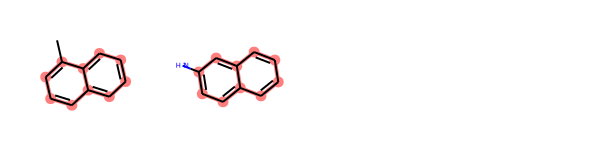

In [10]:
draw_mols((a_methyl_naphthalene, b_amino_naphthalene),
          mcs_res=a_methyl_b_amino_naphthalene_res)

This is the MCS i'd like to see between &alpha;-methylnaphthalene and &beta;-methylnaphthalene, <i>i.e.</i> the same as before:

In [11]:
b_methyl_naphthalene = Chem.MolFromSmiles("Cc1ccc2ccccc2c1")

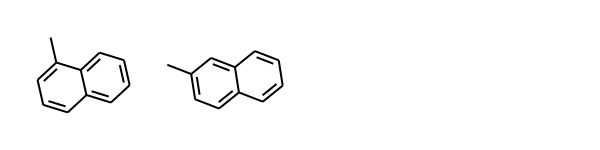

In [12]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene))

In [13]:
a_methyl_b_methyl_naphthalene_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, b_methyl_naphthalene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [14]:
a_methyl_b_methyl_naphthalene_res.numAtoms

11

In [15]:
a_methyl_b_methyl_naphthalene_res.numBonds

11

The MCS is indeed constituted by the plain naphthalene core:

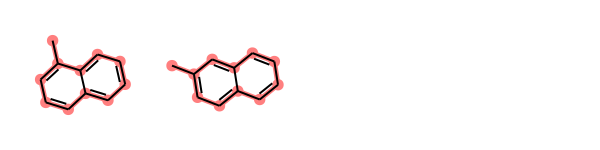

In [16]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene),
          mcs_res=a_methyl_b_methyl_naphthalene_res)

We haven't broken this case:

In [17]:
a_b_dimethyl_naphthalene = Chem.MolFromSmiles("Cc1c(C)ccc2ccccc12")

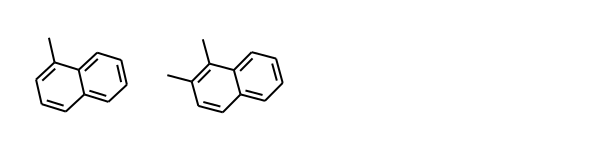

In [18]:
draw_mols((a_methyl_naphthalene, a_b_dimethyl_naphthalene))

In [19]:
a_methyl_a_b_dimethyl_naphthalene_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, a_b_dimethyl_naphthalene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [20]:
a_methyl_a_b_dimethyl_naphthalene_res.numAtoms

11

In [21]:
a_methyl_a_b_dimethyl_naphthalene_res.numBonds

12

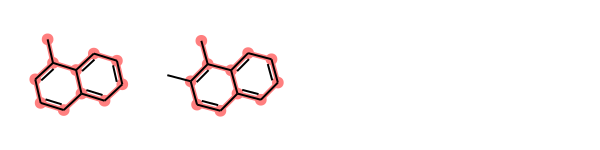

In [22]:
draw_mols((a_methyl_naphthalene, a_b_dimethyl_naphthalene),
          mcs_res=a_methyl_a_b_dimethyl_naphthalene_res)

And the MCS between &alpha;-methylnaphthalene, &beta;-aminonaphthalene and methylciclodecapentaene is ethane only, as cyclodecapentaene and naphthalene are indeed completely different ring systems (cyclodecapentaene is not even aromatic due to distorted planarity) and in my opinion should not match:

In [23]:
cyclodecapentaene = Chem.MolFromSmiles("Cc1ccccccccc1")

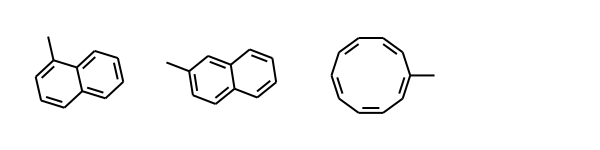

In [24]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene, cyclodecapentaene))

In [25]:
amn_bmn_cdp_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, b_methyl_naphthalene, cyclodecapentaene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [26]:
amn_bmn_cdp_res.numAtoms

11

In [27]:
amn_bmn_cdp_res.numBonds

11

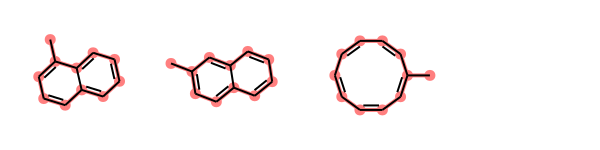

In [28]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene, cyclodecapentaene),
          mcs_res=amn_bmn_cdp_res)

Also this case looks better to me:

In [29]:
a_methyl_bcn = Chem.MolFromSmiles("CC1CCCC2CCCC12")

In [30]:
b_methyl_bcn = Chem.MolFromSmiles("C1C(C)CCC2CCCC12")

In [31]:
a_methyl_tcd = Chem.MolFromSmiles("CC1CCCC(C3)2CCCC123")

In [32]:
b_methyl_tcd = Chem.MolFromSmiles("C1C(C)CCC(C3)2CCCC123")

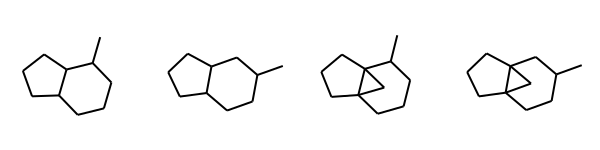

In [33]:
draw_mols((a_methyl_bcn, b_methyl_bcn, a_methyl_tcd, b_methyl_tcd))

In [34]:
a_b_bcn_a_b_tcd_res = rdFMCS.FindMCS(
    (a_methyl_bcn, b_methyl_bcn, a_methyl_tcd, b_methyl_tcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [35]:
a_b_bcn_a_b_tcd_res.numAtoms

10

In [36]:
a_b_bcn_a_b_tcd_res.numBonds

10

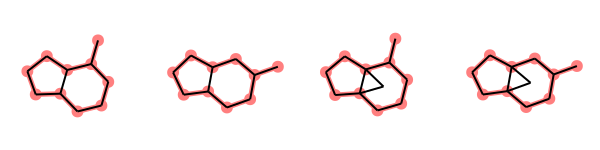

In [37]:
draw_mols((a_methyl_bcn, b_methyl_bcn, a_methyl_tcd, b_methyl_tcd),
          mcs_res=a_b_bcn_a_b_tcd_res)

This still works as it used to:

In [38]:
a_bcn_a_tcd_res = rdFMCS.FindMCS(
    (a_methyl_bcn, a_methyl_tcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [39]:
a_bcn_a_tcd_res.numAtoms

10

In [40]:
a_bcn_a_tcd_res.numBonds

11

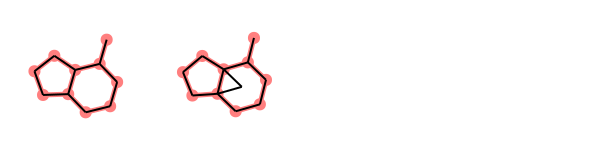

In [41]:
draw_mols((a_methyl_bcn, a_methyl_tcd), padding=0.3,
          mcs_res=a_bcn_a_tcd_res)

In [42]:
a_methyl_bch = Chem.MolFromSmiles("CC1CCC2CC12")

In [43]:
b_methyl_bch = Chem.MolFromSmiles("C1C(C)CC2CC12")

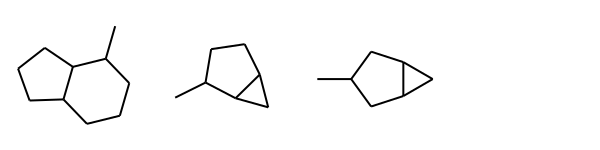

In [44]:
draw_mols((a_methyl_bcn, a_methyl_bch, b_methyl_bch))

Here the MCS is cyclopentane as I believe it ought to be:

In [45]:
a_bcn_a_bch_res = rdFMCS.FindMCS(
    (a_methyl_bcn, a_methyl_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [46]:
a_bcn_a_bch_res.numAtoms

7

In [47]:
a_bcn_a_bch_res.numBonds

7

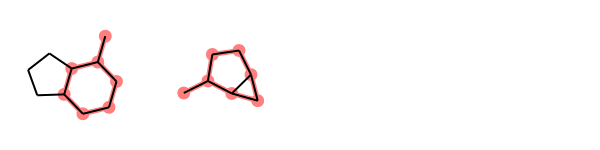

In [48]:
draw_mols((a_methyl_bcn, a_methyl_bch), padding=0.3,
          mcs_res=a_bcn_a_bch_res)

In [49]:
a_bcn_a_bch_res.smartsString

'[#6&!R]-&!@[#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@1'

As in the modified code the methyl group is not part of the MCS anymore, the ring <i>vs</i> non-ring match does not show up:

In [50]:
a_bcn_b_bch_res = rdFMCS.FindMCS(
    (a_methyl_bcn, b_methyl_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [51]:
a_bcn_b_bch_res.numAtoms

7

In [52]:
a_bcn_b_bch_res.numBonds

7

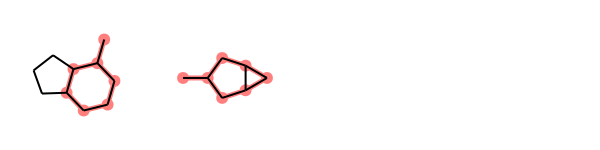

In [53]:
draw_mols((a_methyl_bcn, b_methyl_bch), padding=0.3,
          mcs_res=a_bcn_b_bch_res)

However, when I print the `smartsString` I can see that in my patched version bonds feature ring/non-ring specifiers...

In [54]:
a_bcn_b_bch_res.smartsString

'[#6&R]1-&@[#6&R](-&!@[#6&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@1'

...as in Andrew Dalke's original MCS implementation:

In [55]:
a_bcn_b_bch_res_legacy = rdFMCS.FindMCS(
    (a_methyl_bcn, b_methyl_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [56]:
a_bcn_b_bch_res_legacy.numAtoms

7

In [57]:
a_bcn_b_bch_res_legacy.numBonds

7

All bonds are properly labeled:

In [58]:
#a_bcn_b_bch_res_legacy.smarts

And the MCS is indeed correct:

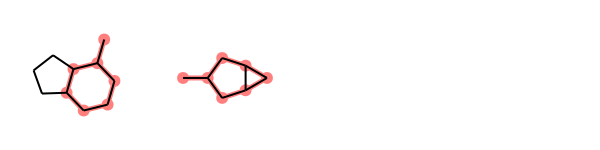

In [59]:
draw_mols((a_methyl_bcn, b_methyl_bch), padding=0.3,
          mcs_res=a_bcn_b_bch_res_legacy)

Here I can verify that the ring <i>vs</i> non-ring match bug is indeed fixed, and also the MCS seems more useful than it does in released RDKit:

In [60]:
trimethyl_2_5_8_bcn = Chem.MolFromSmiles("CC1CC(C)CC2CC(C)CC12")

In [61]:
dimethyl_3_6_bch = Chem.MolFromSmiles("C1C(C)CC2C(C)C12")

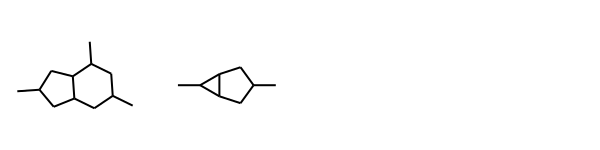

In [62]:
draw_mols((trimethyl_2_5_8_bcn, dimethyl_3_6_bch))

In [63]:
tmbcn_dmbch_res = rdFMCS.FindMCS(
    (trimethyl_2_5_8_bcn, dimethyl_3_6_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

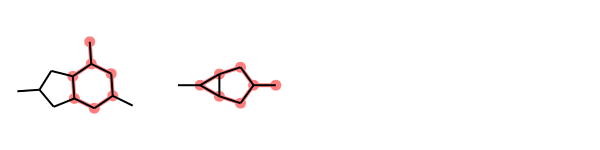

In [64]:
draw_mols((trimethyl_2_5_8_bcn, dimethyl_3_6_bch), mcs_res=tmbcn_dmbch_res)

This test case still works OK:

In [65]:
a_methyl_bcd = Chem.MolFromSmiles("CC1CCCC2(C3)CCCC123")

In [66]:
b_methyl_bcd = Chem.MolFromSmiles("C1C(C)CCC2(C3)CCCC123")

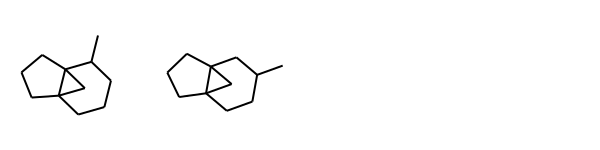

In [67]:
draw_mols((a_methyl_bcd, b_methyl_bcd))

In [68]:
a_methyl_bcd_b_methyl_bcd_res = rdFMCS.FindMCS(
    (a_methyl_bcd, b_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

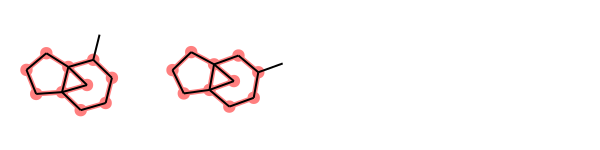

In [69]:
draw_mols((a_methyl_bcd, b_methyl_bcd), mcs_res=a_methyl_bcd_b_methyl_bcd_res)

Here again I get a more useful MCS:

In [70]:
a_methyl_bcd_dimethyl_3_6_bch_res = rdFMCS.FindMCS(
    (a_methyl_bcd, dimethyl_3_6_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

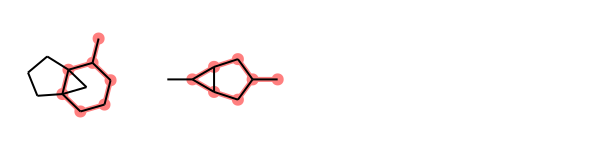

In [71]:
draw_mols((a_methyl_bcd, dimethyl_3_6_bch),
          mcs_res=a_methyl_bcd_dimethyl_3_6_bch_res)

In [72]:
a_methyl_bcn_a_methyl_bcd_res = rdFMCS.FindMCS(
    (a_methyl_bcn, a_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

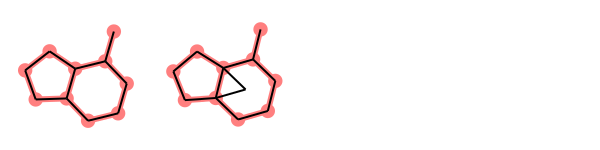

In [73]:
draw_mols((a_methyl_bcn, a_methyl_bcd),
          mcs_res=a_methyl_bcn_a_methyl_bcd_res)

In [74]:
b_methyl_bcn_a_methyl_bcd_res = rdFMCS.FindMCS(
    (b_methyl_bcn, a_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

And here, too:

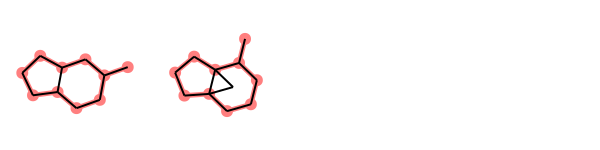

In [75]:
draw_mols((b_methyl_bcn, a_methyl_bcd),
          mcs_res=b_methyl_bcn_a_methyl_bcd_res)

In [76]:
methyl_2_bch = Chem.MolFromSmiles("CC1CCC2CC12")

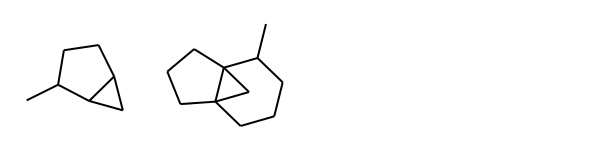

In [77]:
draw_mols((methyl_2_bch, a_methyl_bcd))

In [78]:
methyl_2_bch_a_methyl_bcd_res = rdFMCS.FindMCS(
    (methyl_2_bch, a_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

Ditto:

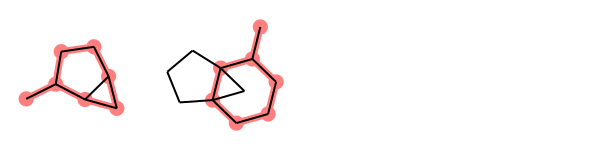

In [79]:
draw_mols((methyl_2_bch, a_methyl_bcd),
          mcs_res=methyl_2_bch_a_methyl_bcd_res)

The MCS between methylcyclopentane and methylcyclohexane is now correct as in Andrew Dalke's implementation:

In [80]:
methylcyclopentane = Chem.MolFromSmiles("CC1CCCC1")

In [81]:
methylcyclohexane = Chem.MolFromSmiles("CC1CCCCC1")

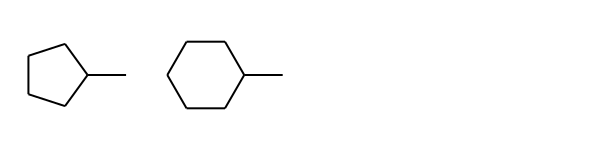

In [82]:
draw_mols((methylcyclopentane, methylcyclohexane))

In [83]:
mcp_mch_res = rdFMCS.FindMCS(
    (methylcyclopentane, methylcyclohexane),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [84]:
mcp_mch_res.numAtoms

2

In [85]:
mcp_mch_res.numBonds

1

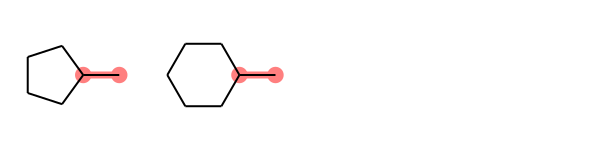

In [86]:
draw_mols((methylcyclopentane, methylcyclohexane), mcs_res=mcp_mch_res)

This is what the original MCS code produced:

In [87]:
mcp_mch_res_legacy = rdFMCS.FindMCS(
    (methylcyclopentane, methylcyclohexane),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [88]:
mcp_mch_res_legacy.numAtoms

2

In [89]:
mcp_mch_res_legacy.numBonds

1

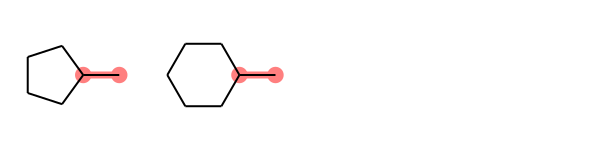

In [90]:
draw_mols((methylcyclopentane, methylcyclohexane), mcs_res=mcp_mch_res_legacy)

And the ethyl derivatives still work OK just as they used to in the released RDKit code:

In [91]:
ethylcyclopentane = Chem.MolFromSmiles("CCC1CCCC1")

In [92]:
ethylcyclohexane = Chem.MolFromSmiles("CCC1CCCCC1")

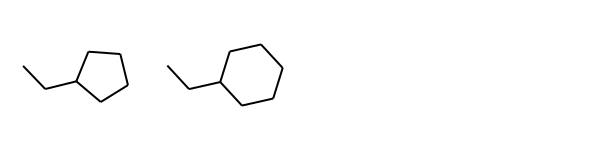

In [93]:
draw_mols((ethylcyclopentane, ethylcyclohexane))

In [94]:
ecp_ech_res = rdFMCS.FindMCS(
    (ethylcyclopentane, ethylcyclohexane),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [95]:
ecp_ech_res.numAtoms

3

In [96]:
ecp_ech_res.numBonds

2

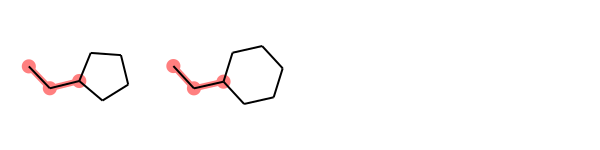

In [97]:
draw_mols((ethylcyclopentane, ethylcyclohexane), mcs_res=ecp_ech_res)

So do acetaldehyde and propene:

In [98]:
acetaldehyde = Chem.MolFromSmiles("CC=O")

In [99]:
propene = Chem.MolFromSmiles("CC=C")

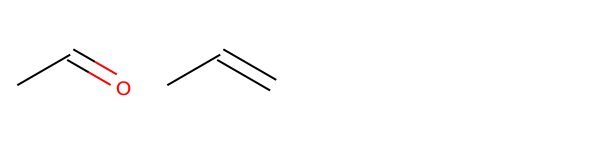

In [100]:
draw_mols((acetaldehyde, propene))

In [101]:
acetaldehyde_propene_res = rdFMCS.FindMCS(
    (acetaldehyde, propene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

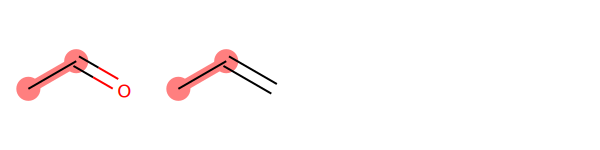

In [102]:
draw_mols((acetaldehyde, propene), mcs_res=acetaldehyde_propene_res)